In [1]:
import numpy as np
from sklearn.externals import joblib
import copy
import random
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import metrics
import matplotlib as mp

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
mp.rcParams.update({'font.size': 18})

In [4]:
datadict = joblib.load("Two_Port_Standard_Dictionary_Cleaned_Interpolated.pkl")

In [5]:
num_fake_points = 15000
magS11_deviation = 0.003
magS21_deviation = 0.0001
magS22_deviation = 0.003
frequency_range = np.linspace(2,18,50)
exempt_values = 2

In [6]:
print datadict['CTN210']['System 2,7'].keys()

['04 Feb 00', '12 Jul 01', '15 Sep 99', '14 Sep 99', '29 May 02', '30 May 02', '28 Feb 01', '11 Jul 01', '01 Mar 01']


In [7]:
magS11_points = []
magS21_points = []
magS22_points = []
for i in range(num_fake_points):
    new_dataset = copy.deepcopy(datadict['CTN210']['System 2,7'][random.choice(datadict['CTN210']['System 2,7'].keys()[:(exempt_values*-1)])])
    new_dataset["magS11"] += np.random.normal(0,magS11_deviation,50)
    new_dataset["magS21"] += np.random.normal(0,magS21_deviation,50)
    new_dataset["magS22"] += np.random.normal(0,magS22_deviation,50)
    magS11_points.append(new_dataset["magS11"].tolist())
    magS21_points.append(new_dataset["magS21"].tolist())
    magS22_points.append(new_dataset["magS22"].tolist())
magS11_arr = np.array(magS11_points)
magS21_arr = np.array(magS21_points)
magS22_arr = np.array(magS22_points)

In [8]:
names = ["Gaussian Naive Bayes",
         "Decision Tree",
         "Random Forest",
         "Quadratic Discriminant Analysis",
         "Voting"]
classifiers = [GaussianNB(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               QuadraticDiscriminantAnalysis(),
               VotingClassifier(estimators=[
                   ('gnb',GaussianNB()),
                   ('rf',RandomForestClassifier()),
                   ('dt',DecisionTreeClassifier()),
                   ('qda',QuadraticDiscriminantAnalysis())
               ],voting="soft")]

In [9]:
def test_actual_values(randomness_amplitude, classifier):
    #Generating Bad Data
    incorrect_magS21_data = copy.deepcopy(magS21_arr)
    for i in range(len(incorrect_magS21_data)):
        incorrect_magS21_data[i] = (incorrect_magS21_data[i] + np.random.normal(0,randomness_amplitude,50))
    #Making training and test data
    S21_training_data = []
    S21_training_data.extend(incorrect_magS21_data.tolist())
    S21_training_data.extend(magS21_arr.tolist())
    S21_training_data_arr = np.array(S21_training_data)
    targets = ["not valid","valid"]
    S21_target_arr = np.repeat(targets,len(magS21_arr))
    S21_training_data_arr,S21_target_arr = shuffle(S21_training_data_arr,S21_target_arr, random_state=0)
    clf = clone(classifier)
    clf.fit(S21_training_data_arr[:len(magS21_arr)],S21_target_arr[:len(magS21_arr)])
    truekeys = datadict['CTN210']['System 2,7'].keys()[(exempt_values*-1):]
    prediction_dict = []
    for key in truekeys:
        prediction_dict.append(datadict["CTN210"]["System 2,7"][key]["magS21"])
    prediction_arr = np.array(prediction_dict)
    return clf.predict(prediction_arr)

In [17]:
result_test_range = np.arange(0.0001,0.0005,0.00005).tolist()
num_func_iterations = 25
results = {}
for index in range(len(classifiers)):
    results[names[index]] = []
    for amp in result_test_range:
        things = []
        for i in range(num_func_iterations):
            vals = test_actual_values(amp, classifiers[index])
            for v in vals:
                if v == "valid":
                    things.append(1)
                else:
                    things.append(0)
        results[names[index]].append(sum(things)/float(len(things)))
    print "Finished Classifier!"

Finished Classifier!
Finished Classifier!
Finished Classifier!
Finished Classifier!
Finished Classifier!


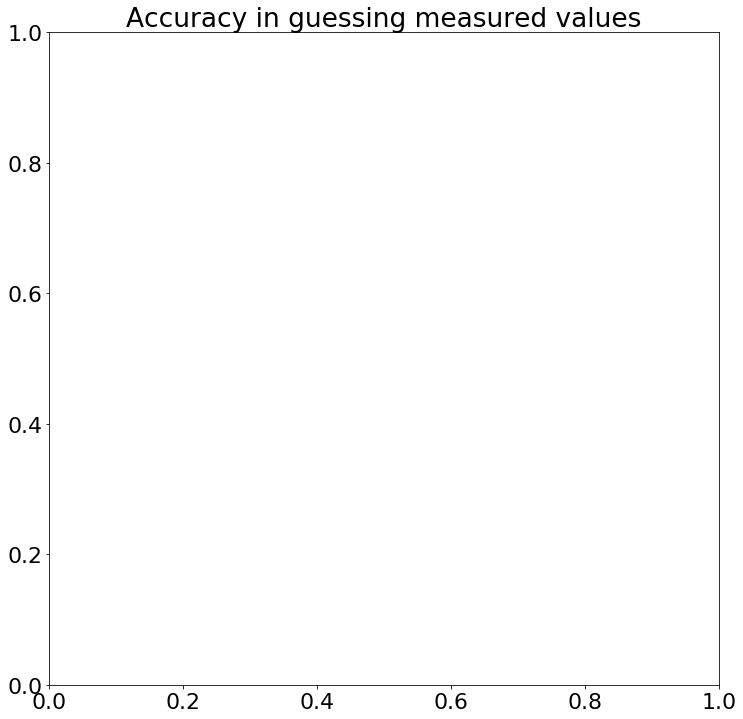

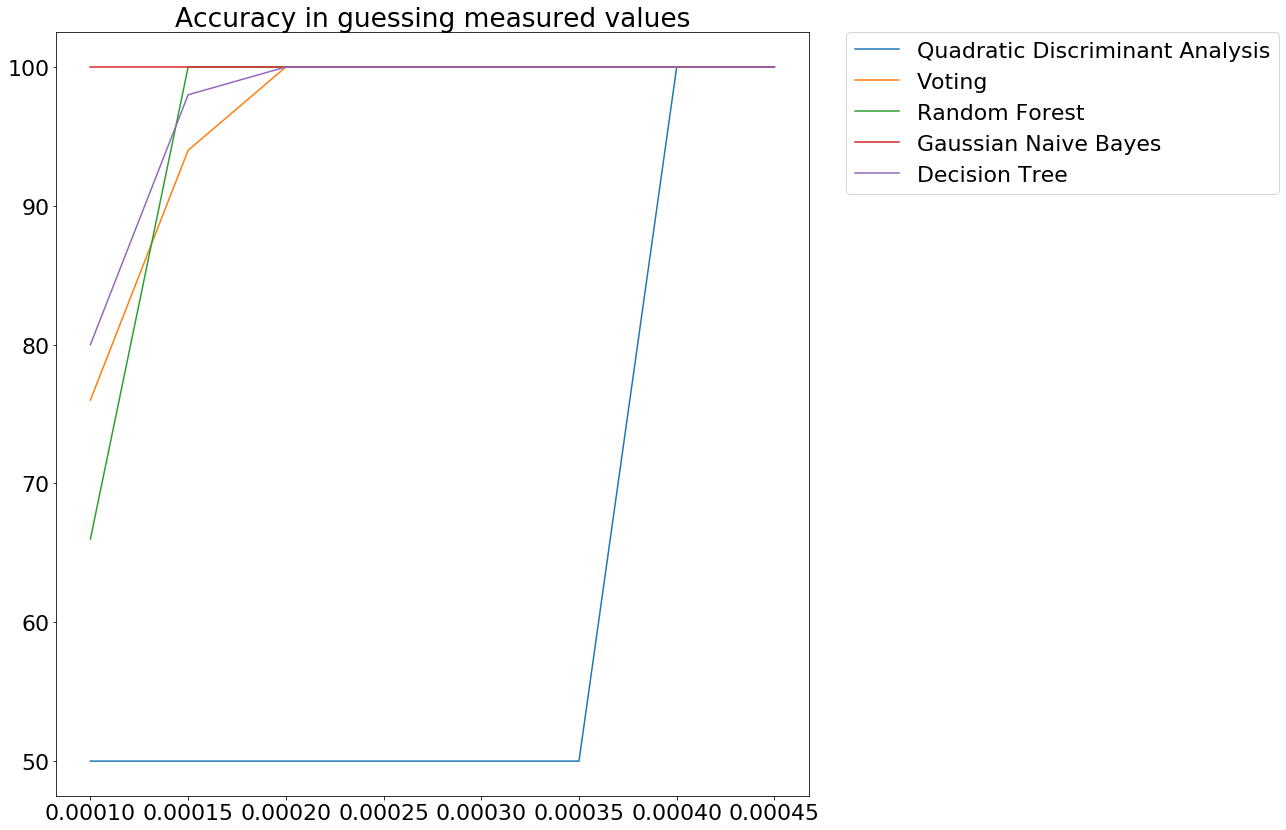

In [22]:
plt.figure(figsize=(12,12))
fighandles = []
plt.title("Accuracy in guessing measured values")
for key in results.keys():
    fighandles.extend(plt.plot(result_test_range,np.array(results[key])*100,label=key))
plt.legend(handles=fighandles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()